# Import

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import psycopg2
import calendar

# DataBase Connection

In [2]:
conn = psycopg2.connect(
    host='hp-dev-db-12sep.cgitnjqny0tw.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='hp_read_user',
    password='hp_@_2023_321',
    database='postgres'
)

# Extract and Derive Data

In [3]:
query1 = """select created::date, id, order_status, ordered_via, user_id, order_amount from sales_userorderdata;"""

query2 = """select created::date, order_id, product_name, quantity from sales_userorderproductsizedata"""

In [4]:
e=pd.read_sql(query1,conn)
e.columns = ["created", "order_id", "order_status", "order_channel", "user_id", "order_amount"]
e['created'] = pd.to_datetime(e['created'])
#OrderCount, ASP, AOV, GMV, Acquistion Ratio, Repeat Rate

f = pd.read_sql(query2,conn)
f.columns = ["created", "order_id", "product_name", "quantity"]
f['created'] = pd.to_datetime(f['created'])
OrderSKUMap=f.groupby('order_id').agg(
        SKUs=pd.NamedAgg(column='product_name', aggfunc= 'nunique'),
        Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
    ).reset_index()

# Set Data Columns
e['OrderDate']=e['created'].dt.date
e['OrderDate']=pd.to_datetime(e['OrderDate'])
#Delta Columns
e['DeltaDaysinOrders']=(e.groupby('user_id').OrderDate.shift() - e.OrderDate).dt.days.abs()
e['DeltaOrderValues']=(e.groupby('user_id').order_amount.shift() - e.order_amount)
#Analysis Parameters


x1=e.groupby('user_id').agg(
        LastDate=pd.NamedAgg(column='OrderDate', aggfunc= 'max'),
        FirstDate=pd.NamedAgg(column='OrderDate', aggfunc='min'),

    ).reset_index()


e2=e.merge(x1[['user_id','LastDate','FirstDate']], left_on='user_id', right_on='user_id')
e2=e2.merge(OrderSKUMap, left_on='order_id', right_on='order_id', how='left')

e2['TrxnRank'] = e2.groupby('user_id')['OrderDate'].rank(method='first')
# e2=e2[e2['OrderDate']>='2022-01-01']
# e2=e2[e2['OrderDate']<='2022-12-31']


#fetch metrices

e2['New']=0
e2.loc[e2['TrxnRank']==1,'New']=1
e2['Repeat']=0
e2.loc[e2['TrxnRank']>1,'Repeat']=1
e2_copy = e2.copy()
e2 = e2[e2["New"] == 1]

# e2['order_id']=e2['order_id_x']
y2=e2.groupby('OrderDate').agg(
        OrderCounts=pd.NamedAgg(column='order_id', aggfunc= 'count'),
        TotalOrderValue=pd.NamedAgg(column='order_amount', aggfunc='sum'),
        AOV=pd.NamedAgg(column='order_amount', aggfunc='mean'),
    Quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
SKUCount=pd.NamedAgg(column='SKUs', aggfunc='sum'),

    ).reset_index()

cancelled_orders = e2[e2['order_status'] == 'Cancelled'].groupby('OrderDate').agg(
    CancellationCount=pd.NamedAgg(column='order_id', aggfunc='count')
).reset_index()

delivered_orders = e2[e2['order_status'] == 'Delivered'].groupby('OrderDate').agg(
    DeliveryCount=pd.NamedAgg(column='order_id', aggfunc='count')
).reset_index()

y3=e2.groupby(['OrderDate', "user_id"]).agg(
        TotalOrderValue=pd.NamedAgg(column='order_amount', aggfunc='sum'),
    Quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
SKUCount=pd.NamedAgg(column='SKUs', aggfunc='sum'),
).reset_index()
y3['UserRank']=y3.groupby('user_id')['OrderDate'].rank(method='first')
y3 = y3.groupby('OrderDate').agg(
    NewUserCount=pd.NamedAgg(column='UserRank', aggfunc=lambda x: (x == 1.0).sum())
)

y2 = y2.merge(cancelled_orders, on='OrderDate', how='left')
y2 = y2.merge(delivered_orders, on='OrderDate', how='left')
y2['CancellationCount'].fillna(0, inplace=True)
y2['DeliveryCount'].fillna(0, inplace=True)

y2=y2.merge(y3, left_on='OrderDate', right_on='OrderDate')

ordered_via_values = e2['order_channel'].unique()
for ordered_via in ordered_via_values:
    y2[f'Channel_{ordered_via}'] = 0
for ordered_via in ordered_via_values:
    orders_by_channel = e2[e2['order_channel'] == ordered_via].groupby('OrderDate').size()
    y2[f'Channel_{ordered_via}'] = y2['OrderDate'].map(orders_by_channel).fillna(0)

# y2['NewOrderRatio']=y2['NewTrxns']/y2['OrderCounts']
# y2['RepeatOrderRatio']=y2['RepearTrxns']/y2['OrderCounts']
y2['UnitsperOrder']=y2['Quantity']/y2['OrderCounts']
y2['SKUsperOrder']=y2['SKUCount']/y2['OrderCounts']
y2['ASP']=y2['TotalOrderValue']/y2['Quantity']
y2['CancellationRate']=y2['CancellationCount']/y2['OrderCounts']
# y2["RepeatUserCount"] = y2["ActiveUsersCounts"] - y2["NewUserCount"]

metrics=['OrderCounts','TotalOrderValue','AOV','ASP','SKUsperOrder','UnitsperOrder','CancellationCount', 'CancellationRate']
for ordered_via in ordered_via_values:
    metric = f'Channel_{ordered_via}'
    metrics.append(metric)
y2.columns = ["Order_Date", "Order_Counts", "Total_Order_Value", "AOV", "Total_Quantity", "Products_Count", "Cancelled_Order_Counts", "Delivered_Orders_Counts", "New_User_Counts", "Channel_Android App", "Channel_Whatsapp", "Channel_Web App", "Channel_IOS App", "No_Units_per_Order", "No_Products_per_Order", "ASP", "Calcellation_Rate_(in %)"]

C:\Users\vinit\AppData\Local\Temp\ipykernel_9176\2084775847.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  e=pd.read_sql(query1,conn)
C:\Users\vinit\AppData\Local\Temp\ipykernel_9176\2084775847.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  f = pd.read_sql(query2,conn)


In [5]:
y2

,Order_Date,Order_Counts,Total_Order_Value,AOV,Total_Quantity,Products_Count,Cancelled_Order_Counts,Delivered_Orders_Counts,New_User_Counts,Channel_Android App,Channel_Whatsapp,Channel_Web App,Channel_IOS App,No_Units_per_Order,No_Products_per_Order,ASP,Calcellation_Rate_(in %)
0,2019-04-01,143,139000.47,972.031259,1836.0,474.0,6.0,137.0,143,143.0,0.0,0.0,0.0,12.839161,3.314685,75.708317,0.041958
1,2019-04-02,185,250680.49,1355.029676,2469.0,813.0,8.0,177.0,185,185.0,0.0,0.0,0.0,13.345946,4.394595,101.531183,0.043243
2,2019-04-03,215,245067.01,1139.846558,2375.0,778.0,9.0,206.0,215,215.0,0.0,0.0,0.0,11.046512,3.618605,103.186109,0.041860
3,2019-04-04,177,245551.68,1387.297627,2290.0,707.0,2.0,175.0,177,177.0,0.0,0.0,0.0,12.937853,3.994350,107.227808,0.011299
4,2019-04-05,155,273213.26,1762.666194,4628.0,710.0,4.0,151.0,155,155.0,0.0,0.0,0.0,29.858065,4.580645,59.034844,0.025806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,2023-09-11,14,19157.00,1368.357143,99.0,52.0,2.0,3.0,14,9.0,2.0,2.0,1.0,7.071429,3.714286,193.505051,0.142857
1615,2023-10-04,1,161.00,161.000000,1.0,1.0,0.0,0.0,1,0.0,1.0,0.0,0.0,1.000000,1.000000,161.000000,0.000000
1616,2023-10-11,1,665.00,665.000000,3.0,2.0,1.0,0.0,1,0.0,1.0,0.0,0.0,3.000000,2.000000,221.666667,1.000000
1617,2023-10-13,4,0.00,0.000000,0.0,0.0,0.0,0.0,4,0.0,4.0,0.0,0.0,0.000000,0.000000,NaN,0.000000


# Acquisition Seasonality

In [6]:
working_df = y2[["Order_Date", "Total_Order_Value", "AOV", "ASP", "No_Products_per_Order", "No_Units_per_Order", "Cancelled_Order_Counts", "Calcellation_Rate_(in %)", "Channel_Android App", "Channel_Whatsapp", "Channel_Web App", "Channel_IOS App"]]

In [7]:
def day_of_week(df, param):
    df1 = df.rename(columns={df.columns[0]: 'Date', df.columns[1]: 'Value'})
    df1['DayOfWeek'] = df1['Date'].dt.strftime('%A')
    custom_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    df1['DayOfWeek'] = pd.Categorical(df1['DayOfWeek'], categories=custom_order, ordered=True)
    result = df1.groupby('DayOfWeek')['Value'].mean().reset_index()
    result = result.rename(columns={result.columns[1]: "Average_"+df.columns[1]})
    m = result["Average_"+df.columns[1]].mean()
    result["Seasonality_Index"] = (result["Average_"+df.columns[1]] - m)*100/m
    x = f"Average_Weekly_{param}"
    result.columns = ["Day_of_the_Week", x, "Seasonality_Index_(in %)"]
    return result

def day_of_month(df, param):
    df1 = df.rename(columns={df.columns[0]: 'Date', df.columns[1]: 'Value'})
    df1['DayOfMonth'] = df1['Date'].dt.day
    result = df1.groupby('DayOfMonth')['Value'].mean().reset_index()
    result = result.rename(columns={result.columns[1]: "Average_"+df.columns[1]})
    m = result["Average_"+df.columns[1]].mean()
    result["Seasonality_Index"] = (result["Average_"+df.columns[1]] - m)*100/m
    x = f"Average_Monthly_{param}"
    result.columns = ["Month_of_the_Year", x, "Seasonality_Index_(in %)"]
    x = f"Average_Daily_{param}"
    result.columns = ["Day_of_the_Month", x, "Seasonality_Index_(in %)"]
    return result

def month_of_year(df, param):
    df = df.rename(columns={df.columns[0]: 'Date', df.columns[1]: 'Value'})
    df['Month'] = df['Date'].dt.strftime('%B')
    custom_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    df['Month'] = pd.Categorical(df['Month'], categories=custom_order, ordered=True)
    result = df.groupby('Month')['Value'].mean().reset_index()
    result = result.rename(columns={result.columns[1]: "Average_"+df.columns[1]})
    m = result["Average_"+df.columns[1]].mean()
    result["Seasonality_Index"] = (result["Average_"+df.columns[1]] - m)*100/m
    x = f"Average_Monthly_{param}"
    result.columns = ["Month_of_the_Year", x, "Seasonality_Index_(in %)"]
    return result

In [8]:
x = day_of_week(working_df, "OrderCounts")

C:\Users\vinit\AppData\Local\Temp\ipykernel_9176\1264478618.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df1.groupby('DayOfWeek')['Value'].mean().reset_index()


In [9]:
x

,Day_of_the_Week,Average_Weekly_OrderCounts,Seasonality_Index_(in %)
0,Sunday,8663.076404,-59.753653
1,Monday,24363.037965,13.184190
2,Tuesday,26199.264323,21.714809
3,Wednesday,24265.982906,12.733298
4,Thursday,22607.012684,5.026164
5,Friday,22919.012446,6.475632
6,Saturday,21658.485150,0.619558


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


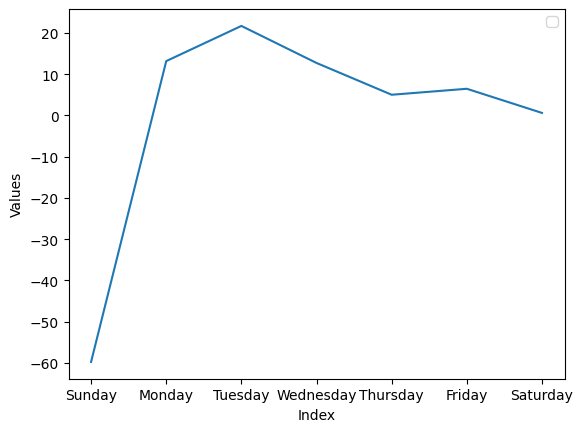

In [10]:
plt.plot(x.iloc[:, 0], x.iloc[:, 2])

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()

# Number of Days for New to Repeat Conversion

In [11]:
gap_new_to_repeat = e2_copy.copy()
gap_new_to_repeat["Gap_between_New_to_Repeat_Trxn_Days"] = -1
for i in range (len(gap_new_to_repeat[gap_new_to_repeat["TrxnRank"] == 2])):
    # if gap_new_to_repeat["TrxnRank"][i] == 2:
    u_id = gap_new_to_repeat["user_id"][i]
    date = gap_new_to_repeat["OrderDate"][i]
    del_days = date - gap_new_to_repeat[(gap_new_to_repeat["user_id"] == u_id) & (gap_new_to_repeat["TrxnRank"] == 1)]["OrderDate"]
    idx = gap_new_to_repeat[(gap_new_to_repeat["user_id"] == u_id) & (gap_new_to_repeat["TrxnRank"] == 1)].index.values[0]
    # print(e2.iloc[idx, 16])
    gap_new_to_repeat.at[idx, "Gap_between_New_to_Repeat_Trxn_Days"] = int(del_days.to_list()[0].days)
    # print(e2.iloc[idx, 16])
gap_new_to_repeat.insert(17, "New_To_Repeat_Conversion_Month", "")

In [12]:
gap_new_to_repeat

,created,order_id,order_status,order_channel,user_id,order_amount,OrderDate,DeltaDaysinOrders,DeltaOrderValues,LastDate,FirstDate,SKUs,Quantity,TrxnRank,New,Repeat,Gap_between_New_to_Repeat_Trxn_Days,New_To_Repeat_Conversion_Month
0,2023-05-17,661977,Delivered,Whatsapp,28044,2996.0,2023-05-17,NaN,NaN,2023-09-02,2020-05-05,6.0,12.0,103.0,0,1,-1,
1,2023-05-11,660111,Delivered,Whatsapp,28044,851.0,2023-05-11,6.0,2145.0,2023-09-02,2020-05-05,2.0,2.0,102.0,0,1,-1,
2,2023-06-15,671240,Delivered,Whatsapp,28044,824.0,2023-06-15,35.0,27.0,2023-09-02,2020-05-05,5.0,5.0,107.0,0,1,-1,
3,2023-07-10,679347,Cancelled,Whatsapp,28044,0.0,2023-07-10,25.0,824.0,2023-09-02,2020-05-05,NaN,NaN,109.0,0,1,-1,
4,2023-07-05,677424,Delivered,Whatsapp,28044,4009.0,2023-07-05,5.0,-4009.0,2023-09-02,2020-05-05,8.0,29.0,108.0,0,1,-1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569427,2023-05-07,658793,Delivered,Android App,56584,495.0,2023-05-07,NaN,NaN,2023-05-07,2023-05-07,1.0,5.0,1.0,1,0,-1,
569428,2023-05-13,660798,Cancelled,IOS App,56755,1327.0,2023-05-13,NaN,NaN,2023-05-13,2023-05-13,6.0,8.0,1.0,1,0,-1,
569429,2023-05-13,660797,Delivered,Android App,56760,2295.0,2023-05-13,NaN,NaN,2023-05-13,2023-05-13,2.0,4.0,1.0,1,0,-1,
569430,2023-05-12,660370,Delivered,Android App,53727,2436.0,2023-05-12,NaN,NaN,2023-05-12,2023-05-12,9.0,19.0,1.0,1,0,-1,


In [13]:
for i in range (len(gap_new_to_repeat)):
    if gap_new_to_repeat.iloc[i, 16] > -1 and gap_new_to_repeat.iloc[i, 16] <=30:
        gap_new_to_repeat.iloc[i, 17] = "1 Month"
    elif gap_new_to_repeat.iloc[i, 16] > 30 and gap_new_to_repeat.iloc[i, 16] <=90:
        gap_new_to_repeat.iloc[i, 17] = "3 Month"
    elif gap_new_to_repeat.iloc[i, 16] > 90 and gap_new_to_repeat.iloc[i, 16] <=180:
        gap_new_to_repeat.iloc[i, 17] = "6 Month"
    elif gap_new_to_repeat.iloc[i, 16] >180:
        gap_new_to_repeat.iloc[i, 17] = "6+ Month"

In [14]:
gap_new_to_repeat[gap_new_to_repeat["Repeat"] == 1]

,created,order_id,order_status,order_channel,user_id,order_amount,OrderDate,DeltaDaysinOrders,DeltaOrderValues,LastDate,FirstDate,SKUs,Quantity,TrxnRank,New,Repeat,Gap_between_New_to_Repeat_Trxn_Days,New_To_Repeat_Conversion_Month
0,2023-05-17,661977,Delivered,Whatsapp,28044,2996.0,2023-05-17,NaN,NaN,2023-09-02,2020-05-05,6.0,12.0,103.0,0,1,-1,
1,2023-05-11,660111,Delivered,Whatsapp,28044,851.0,2023-05-11,6.0,2145.0,2023-09-02,2020-05-05,2.0,2.0,102.0,0,1,-1,
2,2023-06-15,671240,Delivered,Whatsapp,28044,824.0,2023-06-15,35.0,27.0,2023-09-02,2020-05-05,5.0,5.0,107.0,0,1,-1,
3,2023-07-10,679347,Cancelled,Whatsapp,28044,0.0,2023-07-10,25.0,824.0,2023-09-02,2020-05-05,NaN,NaN,109.0,0,1,-1,
4,2023-07-05,677424,Delivered,Whatsapp,28044,4009.0,2023-07-05,5.0,-4009.0,2023-09-02,2020-05-05,8.0,29.0,108.0,0,1,-1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569406,2023-05-14,661184,Delivered,Android App,56798,1369.0,2023-05-14,0.0,-1369.0,2023-05-14,2023-05-14,3.0,10.0,2.0,0,1,-1,
569407,2023-05-13,660951,Cancelled,Android App,56717,1913.0,2023-05-13,NaN,NaN,2023-05-21,2023-05-11,1.0,1.0,3.0,0,1,-1,
569408,2023-05-13,660952,Cancelled,Android App,56717,1913.0,2023-05-13,0.0,0.0,2023-05-21,2023-05-11,1.0,1.0,4.0,0,1,-1,
569410,2023-05-11,660352,Cancelled,Android App,56717,1913.0,2023-05-11,0.0,550.0,2023-05-21,2023-05-11,1.0,1.0,2.0,0,1,-1,


In [15]:
gap_new_to_repeat_days = gap_new_to_repeat[gap_new_to_repeat["Gap_between_New_to_Repeat_Trxn_Days"] != -1][["Gap_between_New_to_Repeat_Trxn_Days"]]

In [16]:
gap_new_to_repeat_days

,Gap_between_New_to_Repeat_Trxn_Days
71,1094
112,95
122,270
133,106
137,0
...,...
22753,392
22808,1463
22838,1436
23138,1492


In [17]:
data = gap_new_to_repeat_days['Gap_between_New_to_Repeat_Trxn_Days']
counts, bin_edges = np.histogram(data, bins=100)
histogram_table = pd.DataFrame({'Number of Days Between First and Second Purchases': bin_edges[:-1], 'Customer Counts': counts})
histogram_table

,Number of Days Between First and Second Purchases,Customer Counts
0,0.00,35
1,15.25,2
2,30.50,5
3,45.75,4
4,61.00,6
...,...,...
95,1448.75,8
96,1464.00,11
97,1479.25,12
98,1494.50,7


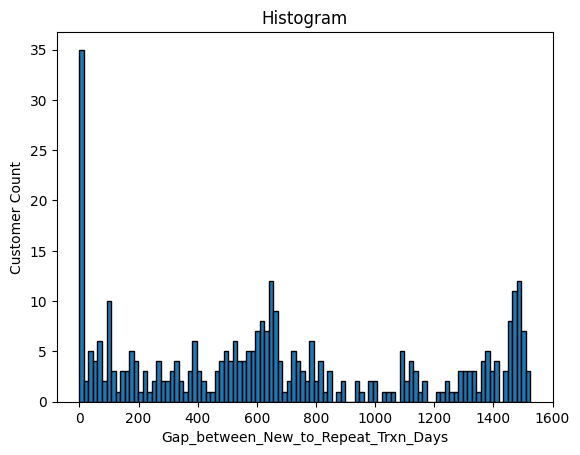

In [18]:
plt.hist(gap_new_to_repeat_days['Gap_between_New_to_Repeat_Trxn_Days'], bins=100, edgecolor='black')
plt.xlabel('Gap_between_New_to_Repeat_Trxn_Days')
plt.ylabel('Customer Count')
plt.title('Histogram')
plt.show()

In [19]:
gap_new_to_repeat_days['Buckets'] = pd.cut(gap_new_to_repeat_days['Gap_between_New_to_Repeat_Trxn_Days'], bins=10, precision=0, include_lowest=False)
decile_table = gap_new_to_repeat_days['Buckets'].value_counts().reset_index()#.sort_values(by = "count", ascending = False)
decile_table.set_index("Buckets", inplace = True)
decile_table = decile_table.sort_values(by="Buckets")

labels = decile_table.index.tolist()
user_counts = decile_table["count"].tolist()
bin_df = pd.DataFrame({'Days Gap Between Transactions (Lower Limit)': [label.left for label in labels],
                       'Days Gap Between Transactions (Upper Limit)': [label.right for label in labels],
                       'Customer Count': user_counts})
bin_df[['Days Gap Between Transactions (Lower Limit)', 'Days Gap Between Transactions (Upper Limit)']] = bin_df[['Days Gap Between Transactions (Lower Limit)', 'Days Gap Between Transactions (Upper Limit)']].apply(lambda x: x.clip(lower=0))
bin_df["No of Days Gap Between Transactions"] = bin_df[["Days Gap Between Transactions (Lower Limit)", "Days Gap Between Transactions (Upper Limit)"]].astype("str").apply("-".join, axis=1)

for i in range(len(bin_df)):
    x = str(bin_df.iloc[i, 3])
    a = (x.split("-")[0])[:-2]
    b = (x.split("-")[1])[:-2]
    x = a + " - " + b + " Days"
    bin_df.iloc[i, 3] = x
bin_df = bin_df[["No of Days Gap Between Transactions", "Customer Count"]]

In [20]:
bin_df = bin_df.T
bin_df.columns = bin_df.iloc[0]
bin_df = bin_df.iloc[1:]
bin_df

No of Days Gap Between Transactions,0 - 152 Days,152 - 305 Days,305 - 458 Days,458 - 610 Days,610 - 762 Days,762 - 915 Days,915 - 1068 Days,1068 - 1220 Days,1220 - 1372 Days,1372 - 1525 Days
Customer Count,71,27,26,47,55,21,10,18,22,56


# Monthly Conversion Rate

In [21]:
e2_copy["MonthYear"] = e2_copy["created"].dt.strftime("%Y-%m")

In [22]:
e2_copy_1 = e2_copy.copy()

In [23]:
new_users_1 = e2_copy[e2_copy['New'] == 1][['MonthYear', 'user_id']]

In [24]:
e2_copy_2 = e2_copy_1[['user_id', 'MonthYear']]

In [25]:
# Merge the two DataFrames on 'user_id' and 'MonthYear'
merged_df = pd.merge(new_users_1, e2_copy_2, on=['user_id', 'MonthYear'], how='inner')

# Group by 'user_id' and 'MonthYear' and count the occurrences
user_counts = merged_df.groupby(['user_id', 'MonthYear']).size().reset_index(name='count')

# Convert the result to a dictionary if needed
new_user_counts_ordered_again = {(row['user_id'], row['MonthYear']): row['count'] for _, row in user_counts.iterrows()}

In [26]:
filtered_data = {key: value for key, value in new_user_counts_ordered_again.items() if value != 1}

In [27]:
sum_dict = {}

for key, _ in filtered_data.items():
    _, year_month = key
    if year_month in sum_dict:
        sum_dict[year_month] += 1  # Increment the count by one
    else:
        sum_dict[year_month] = 1

sorted_result_1 = dict(sorted(sum_dict.items()))

In [28]:
new_users_df = e2_copy_1[e2_copy_1['New'] == 1]
new_users_per_month = new_users_df.groupby('MonthYear').size().reset_index(name='NewUserCount')
result_dict = dict(zip(new_users_per_month["MonthYear"], new_users_per_month["NewUserCount"]))

In [29]:
result_dict_1 = {key: sum_dict[key] / result_dict[key] for key in sum_dict}
sorted_result = dict(sorted(result_dict_1.items()))

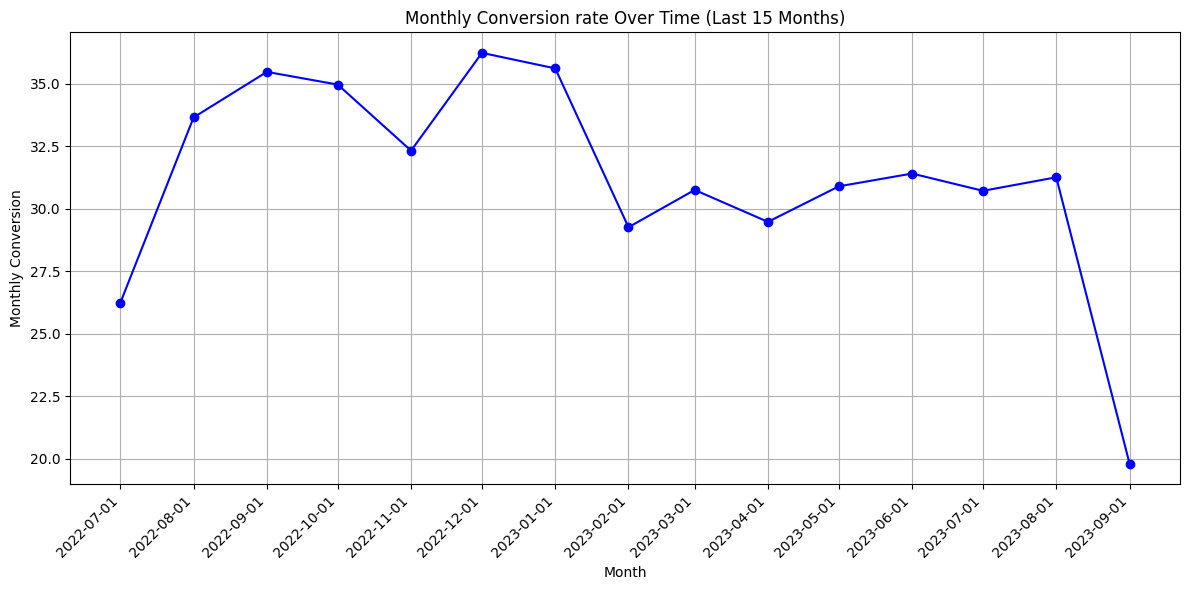

In [30]:
df = pd.DataFrame(list(sorted_result.items()), columns=['Month', 'Decimal'])
df['Month'] = pd.to_datetime(df['Month'])
df = df.sort_values(by='Month')
df = df[-16:-1]
df['Decimal'] = df['Decimal'] * 100

plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['Decimal'], marker='o', linestyle='-', color='b')
plt.title('Monthly Conversion rate Over Time (Last 15 Months)')
plt.xlabel('Month')
plt.ylabel('Monthly Conversion')
plt.xticks(df['Month'], rotation=45, ha='right')  # Set x-axis ticks to include all weeks
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
e2_copy_1['WeekCount']=e2_copy_1['created'].dt.strftime('%Y-w%U')

In [32]:
e2_copy_3 = e2_copy_1.copy()

In [33]:
new_users_week = e2_copy_3[e2_copy_3['New'] == 1][['WeekCount', 'user_id']]

In [34]:
week_df_mini = e2_copy_3[['user_id', 'WeekCount']]

In [35]:
# Merge the two DataFrames on 'user_id' and 'MonthYear'
merged_df_week = pd.merge(new_users_week, week_df_mini, on=['user_id', 'WeekCount'], how='inner')

# Group by 'user_id' and 'MonthYear' and count the occurrences
user_counts_week = merged_df_week.groupby(['user_id', 'WeekCount']).size().reset_index(name='count')

# Convert the result to a dictionary if needed
new_user_counts_ordered_again_week = {(row['user_id'], row['WeekCount']): row['count'] for _, row in user_counts_week.iterrows()}

In [36]:
filtered_data_week = {key: value for key, value in new_user_counts_ordered_again_week.items() if value != 1}

In [37]:
sum_dict_week = {}

for key, _ in filtered_data_week.items():
    _, year_week = key
    if year_week in sum_dict_week:
        sum_dict_week[year_week] += 1  # Increment the count by one
    else:
        sum_dict_week[year_week] = 1

sorted_result_week = dict(sorted(sum_dict_week.items()))

In [38]:
new_users_df_week = e2_copy_3[e2_copy_3['New'] == 1]
new_users_per_week = new_users_df_week.groupby('WeekCount').size().reset_index(name='NewUserCount')
result_dict_week = dict(zip(new_users_per_week["WeekCount"], new_users_per_week["NewUserCount"]))

In [39]:

result_dict_week = {key: sum_dict_week[key] / result_dict_week[key] for key in sum_dict_week}
sorted_result_week = dict(sorted(result_dict_week.items()))

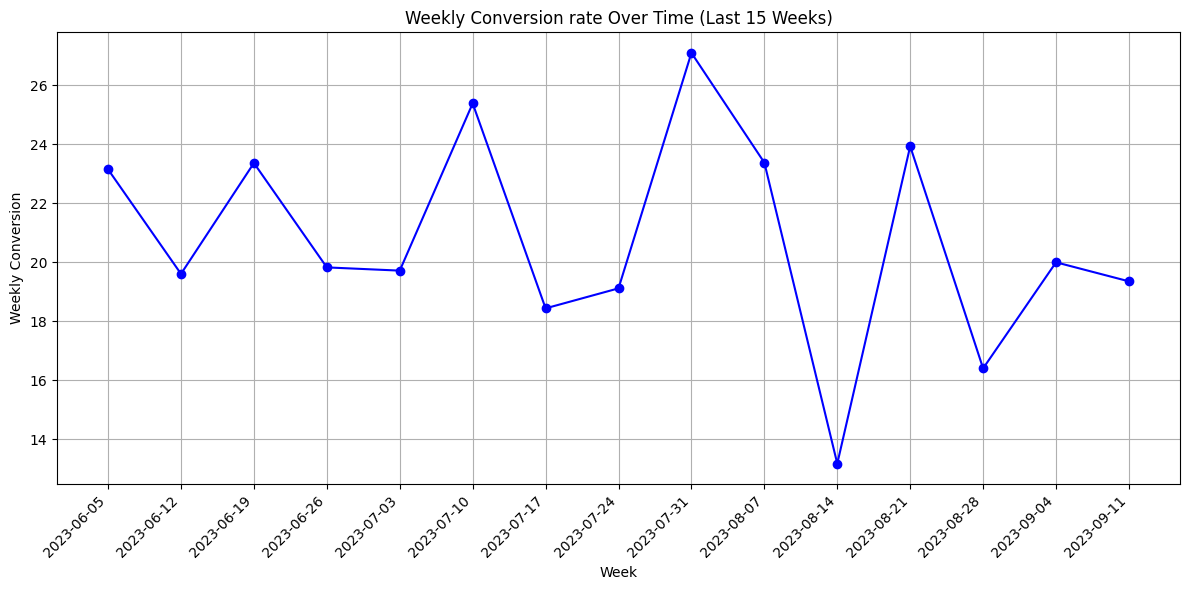

In [40]:
# Convert week format to ISO8601 format (YYYY-Www)
df = pd.DataFrame(list(sorted_result_week.items()), columns=['Week', 'Decimal'])
df['Week'] = df['Week'].apply(lambda x: x[:4] + '-W' + x[6:])
df['Week'] = pd.to_datetime(df['Week'] + '-1', format='%Y-W%U-%w')  # Use %U for the week number (Sunday is the first day of the week)
df = df.sort_values(by='Week')[-16:-1]
df['Decimal'] = df['Decimal'] * 100

plt.figure(figsize=(12, 6))
plt.plot(df['Week'], df['Decimal'], marker='o', linestyle='-', color='b')
plt.title('Weekly Conversion rate Over Time (Last 15 Weeks)')
plt.xlabel('Week')
plt.ylabel('Weekly Conversion')
plt.xticks(df['Week'], rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()